# Approximate Nearest Neighbors (ANN) — Hands-On Demo

This notebook demonstrates why exact KNN breaks at scale and how ANN algorithms solve it.

1. **The problem** — Brute-force KNN timing as data grows
2. **LSH from scratch** — Build Locality-Sensitive Hashing to understand the core idea
3. **IVF from scratch** — Build an Inverted File Index (cluster-based partitioning)
4. **FAISS** — The industry-standard ANN library (IVF-Flat, IVF-PQ, HNSW)
5. **HNSW** — Graph-based ANN via hnswlib (state-of-the-art)
6. **Annoy** — Tree-based ANN used by Spotify
7. **Benchmark** — Compare all methods on speed, recall, and memory
8. **Recommendation context** — Two-Tower retrieval simulation with FAISS

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from collections import Counter

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

# Verify ANN libraries
import faiss
import hnswlib
from annoy import AnnoyIndex

print(f"FAISS version: {faiss.__version__ if hasattr(faiss, '__version__') else 'installed'}")
print(f"hnswlib: installed")
print(f"annoy: installed")
print("\nAll imports successful!")

FAISS version: 1.13.2
hnswlib: installed
annoy: installed

All imports successful!


---
## Part 1: The Problem — Why Exact KNN Breaks

Exact KNN computes distance to **every** point. As the dataset grows, query time grows linearly.
Let's measure this directly.

In [2]:
DIM = 128   # Embedding dimension (same as Two-Tower model)
K = 100     # Retrieve top-100 candidates

def brute_force_knn(data, query, k):
    """Exact KNN via brute-force: compute ALL distances, sort, take top-k."""
    # Inner product (equivalent to cosine similarity for L2-normalized vectors)
    scores = data @ query.T  # (N, 1)
    top_k_idx = np.argpartition(scores.flatten(), -k)[-k:]
    top_k_idx = top_k_idx[np.argsort(scores.flatten()[top_k_idx])[::-1]]
    return top_k_idx, scores.flatten()[top_k_idx]


# Benchmark across different data sizes
sizes = [1_000, 5_000, 10_000, 50_000, 100_000, 500_000]
brute_times = []

print(f"Brute-force KNN benchmark (dim={DIM}, k={K})")
print(f"{'N':>10s}  {'Time (ms)':>10s}  {'QPS':>10s}  {'Feasible?':>12s}")
print("-" * 48)

for n in sizes:
    data = np.random.randn(n, DIM).astype(np.float32)
    data = data / np.linalg.norm(data, axis=1, keepdims=True)  # L2 normalize
    query = np.random.randn(1, DIM).astype(np.float32)
    query = query / np.linalg.norm(query)

    # Warm up
    brute_force_knn(data, query, K)

    # Time it
    start = time.perf_counter()
    n_trials = 20
    for _ in range(n_trials):
        brute_force_knn(data, query, K)
    elapsed = (time.perf_counter() - start) / n_trials
    brute_times.append(elapsed)

    qps = 1.0 / elapsed
    ok = "OK" if elapsed < 0.010 else "SLOW" if elapsed < 0.050 else "TOO SLOW"
    print(f"{n:>10,d}  {elapsed*1000:>8.2f}ms  {qps:>10,.0f}  {ok:>12s}")

time_10m = brute_times[-1] * (10_000_000 / sizes[-1])
print(f"\nExtrapolated 10M items: ~{time_10m*1000:.0f} ms/query → {1/time_10m:.0f} QPS")
print(f"YouTube needs ~50,000 QPS. Brute-force is ~{50000 / (1/time_10m):.0f}x too slow.")

Brute-force KNN benchmark (dim=128, k=100)
         N   Time (ms)         QPS     Feasible?
------------------------------------------------
     1,000      0.02ms      46,898            OK
     5,000      0.04ms      24,925            OK
    10,000      0.09ms      11,426            OK
    50,000      1.16ms         864            OK
   100,000      1.37ms         732            OK
   500,000      8.58ms         117            OK

Extrapolated 10M items: ~172 ms/query → 6 QPS
YouTube needs ~50,000 QPS. Brute-force is ~8577x too slow.


---
## Part 2: LSH From Scratch

**Locality-Sensitive Hashing**: Design hash functions where similar vectors hash to the same bucket.
At query time, only compare items in matching buckets — skip everything else.

For cosine similarity, the hash function is:
```
h(x) = sign(r · x)    where r is a random vector
```
Two similar vectors have a high probability of getting the same sign → same bucket.

In [13]:
class LSH:
    """
    Locality-Sensitive Hashing for cosine similarity.

    Key parameters:
      num_tables (L): More tables → higher recall, more memory
      num_hashes (K): More hashes per table → fewer candidates per bucket → faster but lower recall

    Trade-off: L↑ improves recall, K↑ improves speed but hurts recall
    """

    def __init__(self, dim, num_tables=10, num_hashes=8):
        self.num_tables = num_tables
        self.num_hashes = num_hashes
        self.dim = dim

        # Random hyperplanes for hashing (each table has its own set)
        self.hyperplanes = [
            np.random.randn(num_hashes, dim).astype(np.float32)
            for _ in range(num_tables)
        ]

        # Hash tables: L tables, each maps hash_key → list of item indices
        self.tables = [{} for _ in range(num_tables)]
        self.data = None

    def _hash(self, vectors, table_idx):
        """Compute hash for a batch of vectors using random projections."""
        # Project onto random hyperplanes and take sign
        projections = vectors @ self.hyperplanes[table_idx].T  # (N, num_hashes)
        bits = (projections > 0).astype(np.int8)               # Binary hash
        # Convert bit array to string key
        return ["".join(map(str, row)) for row in bits]

    def build(self, data):
        """Index all data points into hash tables."""
        self.data = data
        n = len(data)

        for t in range(self.num_tables):
            keys = self._hash(data, t)
            for i, key in enumerate(keys):
                self.tables[t].setdefault(key, []).append(i)

        # Stats
        avg_bucket_size = np.mean([
            np.mean([len(v) for v in table.values()])
            for table in self.tables
        ])
        print(f"LSH built: {n} items, {self.num_tables} tables, "
              f"{self.num_hashes} hashes/table, avg bucket size: {avg_bucket_size:.1f}")

    def query(self, query_vec, k=100):
        """Find approximate K nearest neighbors."""
        query_vec = query_vec.reshape(1, -1)

        # Step 1: Collect candidate indices from all tables
        candidates = set()
        for t in range(self.num_tables):
            key = self._hash(query_vec, t)[0]
            candidates.update(self.tables[t].get(key, []))

        if not candidates:
            return np.array([]), np.array([])

        # Step 2: Exact distance on candidates only (much smaller than full dataset)
        candidate_list = list(candidates)
        candidate_vecs = self.data[candidate_list]
        scores = (candidate_vecs @ query_vec.T).flatten()

        # Step 3: Sort and return top-k
        top_k = min(k, len(candidate_list))
        top_idx = np.argpartition(scores, -top_k)[-top_k:]
        top_idx = top_idx[np.argsort(scores[top_idx])[::-1]]

        result_ids = np.array(candidate_list)[top_idx]
        result_scores = scores[top_idx]
        return result_ids, result_scores


# Demo on 50K items
N = 50_000
data = np.random.randn(N, DIM).astype(np.float32)
data = data / np.linalg.norm(data, axis=1, keepdims=True)
query = np.random.randn(1, DIM).astype(np.float32)
query = query / np.linalg.norm(query)

# Build LSH index
lsh = LSH(dim=DIM, num_tables=15, num_hashes=10)
lsh.build(data)

# Query
lsh_ids, lsh_scores = lsh.query(query, k=K)

# Compare with brute-force ground truth
gt_ids, gt_scores = brute_force_knn(data, query, K)

# Compute recall
recall = len(set(gt_ids) & set(lsh_ids)) / K
print(f"\nLSH results:")
print(f"  Recall@{K}: {recall:.2%}")
print(f"  Candidates examined: {len(lsh_ids)} (out of {N} total)")
print(f"  Speedup: only checked ~{len(lsh_ids)/N:.1%} of the data")

LSH built: 50000 items, 15 tables, 10 hashes/table, avg bucket size: 48.8

LSH results:
  Recall@100: 5.00%
  Candidates examined: 100 (out of 50000 total)
  Speedup: only checked ~0.2% of the data


In [4]:
# Show how LSH parameters affect recall and speed
print(f"{'Tables':>7s}  {'Hashes':>7s}  {'Recall':>8s}  {'Time (ms)':>10s}  {'Candidates':>12s}")
print("-" * 52)

configs = [
    (5,  6),   # Few tables, few hashes → fast but low recall
    (10, 8),   # Medium
    (15, 10),  # More tables → better recall
    (20, 8),   # Even more tables
    (25, 6),   # Many tables, fewer hashes → high recall, more candidates
]

lsh_recalls = []
lsh_times = []

for num_tables, num_hashes in configs:
    lsh_test = LSH(dim=DIM, num_tables=num_tables, num_hashes=num_hashes)
    lsh_test.build(data)

    start = time.perf_counter()
    n_trials = 50
    total_candidates = 0
    total_recall = 0
    for _ in range(n_trials):
        q = np.random.randn(1, DIM).astype(np.float32)
        q = q / np.linalg.norm(q)
        ids, _ = lsh_test.query(q, k=K)
        gt, _ = brute_force_knn(data, q, K)
        total_recall += len(set(gt) & set(ids)) / K
        total_candidates += len(ids)
    elapsed = (time.perf_counter() - start) / n_trials

    avg_recall = total_recall / n_trials
    avg_cands = total_candidates / n_trials
    lsh_recalls.append(avg_recall)
    lsh_times.append(elapsed * 1000)

    print(f"{num_tables:>7d}  {num_hashes:>7d}  {avg_recall:>7.1%}  {elapsed*1000:>8.2f}ms  {avg_cands:>10.0f}")

 Tables   Hashes    Recall   Time (ms)    Candidates
----------------------------------------------------
LSH built: 50000 items, 5 tables, 6 hashes/table, avg bucket size: 781.2
      5        6    19.2%      1.98ms         100
LSH built: 50000 items, 10 tables, 8 hashes/table, avg bucket size: 195.3
     10        8    13.8%      1.61ms         100
LSH built: 50000 items, 15 tables, 10 hashes/table, avg bucket size: 48.8
     15       10     7.6%      1.44ms         100
LSH built: 50000 items, 20 tables, 8 hashes/table, avg bucket size: 195.3
     20        8    25.4%      2.15ms         100
LSH built: 50000 items, 25 tables, 6 hashes/table, avg bucket size: 781.2
     25        6    64.5%      5.23ms         100


---
## Part 3: IVF From Scratch

**Inverted File Index**: Partition the space into clusters (K-means), then at query time
only search the nearest `nprobe` clusters instead of the full dataset.

```
Build: Run K-means on all data → assign each item to its nearest cluster
Query: Find nprobe nearest cluster centroids → search only items in those clusters
```

This is the foundation of FAISS `IndexIVFFlat`.

In [9]:
from sklearn.cluster import MiniBatchKMeans


class SimpleIVF:
    """
    Inverted File Index from scratch.

    Build:
      1. Run K-means to partition data into `nlist` clusters
      2. Assign each item to its nearest centroid
      3. Store items grouped by cluster

    Query:
      1. Find `nprobe` nearest centroids to query
      2. Search only items in those clusters
      3. Return top-k from candidates
    """

    def __init__(self, dim, nlist=100, nprobe=10):
        self.dim = dim
        self.nlist = nlist     # Number of clusters (partitions)
        self.nprobe = nprobe   # Number of clusters to search at query time
        self.centroids = None
        self.inverted_lists = {}  # cluster_id → list of (item_idx, vector)
        self.data = None

    def build(self, data):
        """Cluster data and build inverted lists."""
        self.data = data
        n = len(data)

        # Step 1: K-means clustering
        print(f"Running K-means with {self.nlist} clusters on {n} items...")
        kmeans = MiniBatchKMeans(
            n_clusters=self.nlist, batch_size=min(10000, n),
            n_init=3, random_state=42
        )
        assignments = kmeans.fit_predict(data)
        self.centroids = kmeans.cluster_centers_.astype(np.float32)
        # Normalize centroids for inner product search
        self.centroids = self.centroids / np.linalg.norm(
            self.centroids, axis=1, keepdims=True
        )

        # Step 2: Build inverted lists
        for cluster_id in range(self.nlist):
            mask = assignments == cluster_id
            indices = np.where(mask)[0]
            self.inverted_lists[cluster_id] = indices

        sizes = [len(v) for v in self.inverted_lists.values()]
        print(f"IVF built: {self.nlist} clusters, "
              f"avg size: {np.mean(sizes):.0f}, "
              f"min: {np.min(sizes)}, max: {np.max(sizes)}")

    def query(self, query_vec, k=100):
        """Find approximate K nearest neighbors by searching nprobe clusters."""
        query_vec = query_vec.reshape(1, -1)

        # Step 1: Find nprobe nearest centroids
        centroid_scores = (self.centroids @ query_vec.T).flatten()
        top_clusters = np.argpartition(centroid_scores, -self.nprobe)[-self.nprobe:]

        # Step 2: Collect candidates from those clusters
        candidate_ids = []
        for cluster_id in top_clusters:
            candidate_ids.extend(self.inverted_lists[cluster_id])

        if not candidate_ids:
            return np.array([]), np.array([])

        # Step 3: Exact search on candidates
        candidate_ids = np.array(candidate_ids)
        candidate_vecs = self.data[candidate_ids]
        scores = (candidate_vecs @ query_vec.T).flatten()

        top_k = min(k, len(candidate_ids))
        top_idx = np.argpartition(scores, -top_k)[-top_k:]
        top_idx = top_idx[np.argsort(scores[top_idx])[::-1]]

        return candidate_ids[top_idx], scores[top_idx]


# Build IVF index on 50K items
ivf = SimpleIVF(dim=DIM, nlist=100, nprobe=10)
ivf.build(data)

# Query and measure recall
ivf_ids, ivf_scores = ivf.query(query, k=K)
gt_ids, _ = brute_force_knn(data, query, K)

recall = len(set(gt_ids) & set(ivf_ids)) / K
print(f"\nIVF results (nlist={ivf.nlist}, nprobe={ivf.nprobe}):")
print(f"  Recall@{K}: {recall:.2%}")
print(f"  Searched {ivf.nprobe}/{ivf.nlist} clusters "
      f"= ~{ivf.nprobe/ivf.nlist:.0%} of data")

Running K-means with 100 clusters on 50000 items...
IVF built: 100 clusters, avg size: 500, min: 445, max: 556

IVF results (nlist=100, nprobe=10):
  Recall@100: 34.00%
  Searched 10/100 clusters = ~10% of data


In [10]:
# Show how nprobe controls the recall/speed trade-off
nprobe_values = [1, 3, 5, 10, 20, 30, 50, 100]
ivf_recalls = []
ivf_times = []

print(f"IVF nprobe tuning (nlist={ivf.nlist}, N={N})")
print(f"{'nprobe':>8s}  {'% searched':>10s}  {'Recall':>8s}  {'Time (ms)':>10s}")
print("-" * 42)

for nprobe in nprobe_values:
    ivf.nprobe = nprobe

    start = time.perf_counter()
    n_trials = 50
    total_recall = 0
    for _ in range(n_trials):
        q = np.random.randn(1, DIM).astype(np.float32)
        q = q / np.linalg.norm(q)
        ids, _ = ivf.query(q, k=K)
        gt, _ = brute_force_knn(data, q, K)
        total_recall += len(set(gt) & set(ids)) / K
    elapsed = (time.perf_counter() - start) / n_trials

    avg_recall = total_recall / n_trials
    ivf_recalls.append(avg_recall)
    ivf_times.append(elapsed * 1000)

    pct = nprobe / ivf.nlist * 100
    print(f"{nprobe:>8d}  {pct:>8.0f}%  {avg_recall:>7.1%}  {elapsed*1000:>8.2f}ms")

IVF nprobe tuning (nlist=100, N=50000)
  nprobe  % searched    Recall   Time (ms)
------------------------------------------
       1         1%     4.8%      1.17ms
       3         3%    11.8%      1.29ms
       5         5%    16.3%      1.41ms
      10        10%    28.4%      2.03ms
      20        20%    46.1%      2.83ms
      30        30%    59.3%      3.52ms
      50        50%    78.1%      5.42ms
     100       100%   100.0%     10.21ms


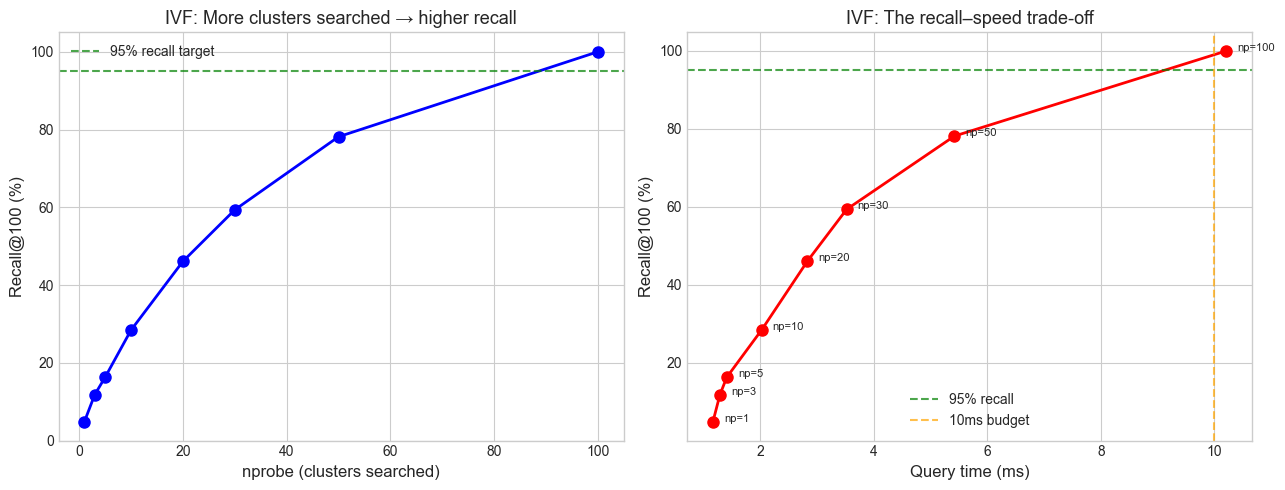

Key insight: nprobe is the knob that trades speed for recall.
In production, you tune nprobe to hit your recall target within your latency budget.


In [11]:
# Visualize the nprobe trade-off
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Recall vs nprobe
ax1.plot(nprobe_values, [r * 100 for r in ivf_recalls], 'bo-', linewidth=2, markersize=8)
ax1.axhline(y=95, color='green', linestyle='--', alpha=0.7, label='95% recall target')
ax1.set_xlabel('nprobe (clusters searched)', fontsize=12)
ax1.set_ylabel('Recall@100 (%)', fontsize=12)
ax1.set_title('IVF: More clusters searched → higher recall', fontsize=13)
ax1.legend(fontsize=10)
ax1.set_ylim(0, 105)

# Recall vs speed
ax2.plot(ivf_times, [r * 100 for r in ivf_recalls], 'ro-', linewidth=2, markersize=8)
for i, nprobe in enumerate(nprobe_values):
    ax2.annotate(f'np={nprobe}', (ivf_times[i], ivf_recalls[i]*100),
                textcoords="offset points", xytext=(8, 0), fontsize=8)
ax2.axhline(y=95, color='green', linestyle='--', alpha=0.7, label='95% recall')
ax2.axvline(x=10, color='orange', linestyle='--', alpha=0.7, label='10ms budget')
ax2.set_xlabel('Query time (ms)', fontsize=12)
ax2.set_ylabel('Recall@100 (%)', fontsize=12)
ax2.set_title('IVF: The recall–speed trade-off', fontsize=13)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

print("Key insight: nprobe is the knob that trades speed for recall.")
print("In production, you tune nprobe to hit your recall target within your latency budget.")

---
## Part 4: FAISS — Industry-Standard ANN

FAISS (Facebook AI Similarity Search) is what YouTube, Instagram, and most large-scale
recommendation systems actually use. Let's see the three main index types.

In [12]:
# Use a larger dataset: 200K items (more realistic for showing ANN benefit)
N_LARGE = 200_000
data_large = np.random.randn(N_LARGE, DIM).astype(np.float32)
faiss.normalize_L2(data_large)  # In-place L2 normalization

query_batch = np.random.randn(100, DIM).astype(np.float32)
faiss.normalize_L2(query_batch)

print(f"Dataset: {N_LARGE:,} items, {DIM}-d, normalized")
print(f"Query batch: {len(query_batch)} queries")
print(f"\n{'Index Type':>20s}  {'Build (s)':>10s}  {'Query (ms)':>12s}  {'Recall@100':>12s}  {'Memory':>10s}")
print("-" * 72)

# --- Ground truth (brute-force) ---
index_flat = faiss.IndexFlatIP(DIM)
index_flat.add(data_large)

start = time.perf_counter()
gt_scores, gt_ids = index_flat.search(query_batch, K)
flat_time = (time.perf_counter() - start) / len(query_batch)
memory_flat = N_LARGE * DIM * 4 / 1e6  # MB
print(f"{'Flat (exact)':>20s}  {'—':>10s}  {flat_time*1000:>10.2f}ms  {'100.0%':>12s}  {memory_flat:>8.1f}MB")


def measure_faiss_index(index, name, needs_training=False):
    """Build, query, and measure recall for a FAISS index."""
    # Build
    build_start = time.perf_counter()
    if needs_training:
        train_sample = data_large[:min(50000, N_LARGE)]
        index.train(train_sample)
    index.add(data_large)
    build_time = time.perf_counter() - build_start

    # Query
    start = time.perf_counter()
    scores, ids = index.search(query_batch, K)
    query_time = (time.perf_counter() - start) / len(query_batch)

    # Recall
    recalls = []
    for i in range(len(query_batch)):
        recall = len(set(gt_ids[i]) & set(ids[i])) / K
        recalls.append(recall)
    avg_recall = np.mean(recalls)

    # Rough memory estimate
    mem = index.ntotal * DIM * 4 / 1e6 if "PQ" not in name else index.ntotal * 32 / 1e6

    print(f"{name:>20s}  {build_time:>9.2f}s  {query_time*1000:>10.2f}ms  "
          f"{avg_recall:>11.1%}  {mem:>8.1f}MB")
    return avg_recall, query_time * 1000


# --- IVF-Flat ---
nlist = 256
quantizer = faiss.IndexFlatIP(DIM)
index_ivf = faiss.IndexIVFFlat(quantizer, DIM, nlist, faiss.METRIC_INNER_PRODUCT)
index_ivf.nprobe = 16
ivf_recall, ivf_time = measure_faiss_index(index_ivf, f"IVF-Flat (np=16)", needs_training=True)

# --- IVF-PQ (compressed) ---
quantizer2 = faiss.IndexFlatIP(DIM)
index_ivfpq = faiss.IndexIVFPQ(quantizer2, DIM, nlist, 32, 8)  # 32 sub-quantizers, 8 bits each
index_ivfpq.nprobe = 32
ivfpq_recall, ivfpq_time = measure_faiss_index(index_ivfpq, f"IVF-PQ (np=32)", needs_training=True)

# --- HNSW ---
index_hnsw = faiss.IndexHNSWFlat(DIM, 32)  # M=32 connections per node
index_hnsw.hnsw.efConstruction = 128
index_hnsw.hnsw.efSearch = 64
index_hnsw.metric_type = faiss.METRIC_INNER_PRODUCT
hnsw_recall, hnsw_time = measure_faiss_index(index_hnsw, f"HNSW (ef=64)")

Dataset: 200,000 items, 128-d, normalized
Query batch: 100 queries

          Index Type   Build (s)    Query (ms)    Recall@100      Memory
------------------------------------------------------------------------
        Flat (exact)           —        0.24ms        100.0%     102.4MB
    IVF-Flat (np=16)       0.27s        0.08ms        24.9%     102.4MB
      IVF-PQ (np=32)       1.95s        0.20ms        29.9%       6.4MB
        HNSW (ef=64)      49.06s        0.07ms        26.7%     102.4MB


---
## Part 5: HNSW via hnswlib (State-of-the-Art)

HNSW builds a hierarchical graph — like express/local stops on a subway.
Top layers have few nodes with long-range links (express). Bottom layers have all nodes with
short-range links (local). Query starts at the top and descends.

`hnswlib` is a fast standalone implementation.

In [14]:
# Build HNSW index with hnswlib
hnsw_index = hnswlib.Index(space='ip', dim=DIM)  # 'ip' = inner product
hnsw_index.init_index(
    max_elements=N_LARGE,
    ef_construction=200,  # Build-time quality (higher = better graph, slower build)
    M=32,                 # Max connections per node
)

# Add data
build_start = time.perf_counter()
hnsw_index.add_items(data_large, np.arange(N_LARGE))
build_time = time.perf_counter() - build_start
print(f"HNSW build time: {build_time:.2f}s")

# Show ef_search tuning
ef_values = [16, 32, 64, 100, 150, 200, 300]
hnsw_recalls = []
hnsw_times = []

print(f"\n{'ef_search':>10s}  {'Recall@100':>12s}  {'Time (ms)':>10s}")
print("-" * 38)

for ef in ef_values:
    hnsw_index.set_ef(ef)

    start = time.perf_counter()
    labels, distances = hnsw_index.knn_query(query_batch, k=K)
    query_time = (time.perf_counter() - start) / len(query_batch)

    recalls = []
    for i in range(len(query_batch)):
        recall = len(set(gt_ids[i]) & set(labels[i])) / K
        recalls.append(recall)
    avg_recall = np.mean(recalls)

    hnsw_recalls.append(avg_recall)
    hnsw_times.append(query_time * 1000)
    print(f"{ef:>10d}  {avg_recall:>11.1%}  {query_time*1000:>8.2f}ms")

HNSW build time: 91.62s

 ef_search    Recall@100   Time (ms)
--------------------------------------


TypeError: 'numpy.int64' object is not iterable

---
## Part 6: Annoy (Spotify)

Annoy (Approximate Nearest Neighbors Oh Yeah) builds a forest of random projection trees.
More trees → better recall, more memory.

In [ ]:
# Build Annoy index
tree_counts = [10, 25, 50, 100, 200]
annoy_recalls = []
annoy_times = []

print(f"{'Trees':>7s}  {'Build (s)':>10s}  {'Recall@100':>12s}  {'Time (ms)':>10s}")
print("-" * 45)

for n_trees in tree_counts:
    annoy_idx = AnnoyIndex(DIM, 'dot')  # dot product (= cosine for normalized)

    build_start = time.perf_counter()
    for i in range(N_LARGE):
        annoy_idx.add_item(i, data_large[i])
    annoy_idx.build(n_trees)
    build_time = time.perf_counter() - build_start

    # Query
    start = time.perf_counter()
    all_ids = []
    for i in range(len(query_batch)):
        ids = annoy_idx.get_nns_by_vector(query_batch[i], K)
        all_ids.append(ids)
    query_time = (time.perf_counter() - start) / len(query_batch)

    # Recall
    recalls = []
    for i in range(len(query_batch)):
        recall = len(set(gt_ids[i]) & set(all_ids[i])) / K
        recalls.append(recall)
    avg_recall = np.mean(recalls)

    annoy_recalls.append(avg_recall)
    annoy_times.append(query_time * 1000)
    print(f"{n_trees:>7d}  {build_time:>9.2f}s  {avg_recall:>11.1%}  {query_time*1000:>8.2f}ms")

    annoy_idx.unload()  # Free memory

---
## Part 7: Grand Comparison — All Methods

Plot all ANN methods on a single recall vs. speed chart.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))

# HNSW (hnswlib)
ax.plot(hnsw_times, [r*100 for r in hnsw_recalls],
        'go-', linewidth=2, markersize=8, label='HNSW (hnswlib)', zorder=5)
for i, ef in enumerate(ef_values):
    ax.annotate(f'ef={ef}', (hnsw_times[i], hnsw_recalls[i]*100),
               textcoords="offset points", xytext=(6, -8), fontsize=7, color='green')

# IVF nprobe sweep
ax.plot(ivf_times, [r*100 for r in ivf_recalls],
        'bs-', linewidth=2, markersize=8, label='IVF-Flat (from scratch)')
for i, np_val in enumerate(nprobe_values):
    ax.annotate(f'np={np_val}', (ivf_times[i], ivf_recalls[i]*100),
               textcoords="offset points", xytext=(6, 4), fontsize=7, color='blue')

# Annoy
ax.plot(annoy_times, [r*100 for r in annoy_recalls],
        'r^-', linewidth=2, markersize=8, label='Annoy (Spotify)')
for i, nt in enumerate(tree_counts):
    ax.annotate(f't={nt}', (annoy_times[i], annoy_recalls[i]*100),
               textcoords="offset points", xytext=(6, -8), fontsize=7, color='red')

# Brute-force reference
brute_time_200k = brute_times[-1] * (N_LARGE / sizes[-1]) * 1000
ax.scatter([brute_time_200k], [100], c='black', s=150, marker='X',
           label='Brute-force (exact)', zorder=5)

# Target zone
ax.axhline(y=95, color='gray', linestyle=':', alpha=0.5)
ax.axvline(x=5, color='gray', linestyle=':', alpha=0.5)
ax.fill_between([0, 5], 95, 100, alpha=0.1, color='green')
ax.text(1, 96, 'Target zone\n(>95% recall, <5ms)', fontsize=9, color='green', alpha=0.8)

ax.set_xlabel('Query time (ms)', fontsize=12)
ax.set_ylabel('Recall@100 (%)', fontsize=12)
ax.set_title(f'ANN Algorithm Comparison ({N_LARGE:,} items, {DIM}-d)\n'
             f'Higher recall + lower time = better (upper-left is best)', fontsize=13)
ax.legend(fontsize=10, loc='lower right')
ax.set_ylim(0, 102)
ax.set_xlim(left=0)

plt.tight_layout()
plt.show()

print("Summary:")
print("  HNSW: Best recall/speed trade-off — use when memory is available")
print("  IVF:  Good all-rounder — easy to tune via nprobe")
print("  Annoy: Simple, good for read-heavy workloads — used by Spotify")
print("  Brute-force: Only for <100K items or ground-truth computation")

---
## Part 8: Recommendation Context — Two-Tower Retrieval Simulation

Simulate the actual Two-Tower + FAISS retrieval pipeline from our video recommendation system.

```
10M videos (precomputed item embeddings in FAISS)
       ↓
User arrives → compute user embedding → FAISS search → top-100 candidates
       ↓
Candidates → Ranking model → Re-ranking → 30 final recommendations
```

In [15]:
# Simulate a video corpus with category structure
N_VIDEOS = 100_000  # 100K videos (use more if your machine can handle it)

categories = ["gaming", "ml_tech", "cooking", "music", "fitness",
              "travel", "comedy", "news", "sports", "education"]

# Each category has a distinct embedding center
np.random.seed(42)
category_centers = {}
for i, cat in enumerate(categories):
    center = np.zeros(DIM, dtype=np.float32)
    # Spread centers apart in embedding space
    center[i*12:(i+1)*12] = np.random.randn(12) * 2.0
    category_centers[cat] = center

# Generate video embeddings with category structure
video_categories = []
video_embeddings = np.zeros((N_VIDEOS, DIM), dtype=np.float32)

for i in range(N_VIDEOS):
    cat = categories[i % len(categories)]
    video_categories.append(cat)
    # Embedding = category center + noise
    video_embeddings[i] = category_centers[cat] + np.random.randn(DIM).astype(np.float32) * 0.5

# L2 normalize (required for inner product = cosine similarity)
faiss.normalize_L2(video_embeddings)

print(f"Video corpus: {N_VIDEOS:,} videos across {len(categories)} categories")
print(f"Embedding dim: {DIM}")
print(f"Categories: {categories}")

Video corpus: 100,000 videos across 10 categories
Embedding dim: 128
Categories: ['gaming', 'ml_tech', 'cooking', 'music', 'fitness', 'travel', 'comedy', 'news', 'sports', 'education']


In [16]:
# Build FAISS index (simulating the ANN service from 05_serving_system.md)
nlist = 256  # Number of IVF clusters

quantizer = faiss.IndexFlatIP(DIM)
video_index = faiss.IndexIVFFlat(quantizer, DIM, nlist, faiss.METRIC_INNER_PRODUCT)

# Train on a sample
print("Training IVF index (K-means clustering)...")
video_index.train(video_embeddings[:50_000])

# Add all videos
video_index.add(video_embeddings)
video_index.nprobe = 16  # Search 16 out of 256 clusters

print(f"Index built: {video_index.ntotal:,} videos, {nlist} clusters, nprobe={video_index.nprobe}")

Training IVF index (K-means clustering)...
Index built: 100,000 videos, 256 clusters, nprobe=16


In [17]:
def simulate_user_embedding(primary_interest, secondary_interest=None):
    """
    Simulate a user embedding from the Two-Tower user tower.

    In production: DNN(user_features) → user_emb
    Here: weighted combination of interest category centers + noise
    """
    emb = category_centers[primary_interest] * 0.7
    if secondary_interest:
        emb += category_centers[secondary_interest] * 0.3
    emb += np.random.randn(DIM).astype(np.float32) * 0.3
    emb = emb / (np.linalg.norm(emb) + 1e-10)
    return emb.reshape(1, -1).astype(np.float32)


def retrieve_and_analyze(user_emb, user_desc, index, k=100):
    """
    Run ANN retrieval and analyze the results by category.
    This simulates what happens in the retrieval stage of our pipeline.
    """
    # ANN search (this is the core retrieval operation)
    start = time.perf_counter()
    scores, indices = index.search(user_emb, k)
    query_time = (time.perf_counter() - start) * 1000

    # Analyze retrieved categories
    retrieved_cats = [video_categories[idx] for idx in indices[0]]
    cat_counts = Counter(retrieved_cats)

    print(f"\n{'='*60}")
    print(f"User: {user_desc}")
    print(f"{'='*60}")
    print(f"Retrieved {k} candidates in {query_time:.2f}ms")
    print(f"\nCategory breakdown:")
    for cat, count in cat_counts.most_common():
        bar = '#' * count
        print(f"  {cat:12s} {count:3d} {bar}")

    print(f"\nTop-5 candidates:")
    for i in range(5):
        idx = indices[0][i]
        print(f"  #{i+1} video_{idx:06d} [{video_categories[idx]:10s}] score={scores[0][i]:.3f}")

    return indices[0], scores[0], query_time


# Simulate 3 different users

# User 1: Pure gaming fan
user1_emb = simulate_user_embedding("gaming")
retrieve_and_analyze(user1_emb, "Gaming fan (single interest)", video_index)

# User 2: ML tech + cooking (multi-interest)
user2_emb = simulate_user_embedding("ml_tech", "cooking")
retrieve_and_analyze(user2_emb, "ML tech (primary) + Cooking (secondary)", video_index)

# User 3: Fitness enthusiast
user3_emb = simulate_user_embedding("fitness")
retrieve_and_analyze(user3_emb, "Fitness enthusiast", video_index)


User: Gaming fan (single interest)
Retrieved 100 candidates in 0.46ms

Category breakdown:
  gaming       100 ####################################################################################################

Top-5 candidates:
  #1 video_058430 [gaming    ] score=0.671
  #2 video_096860 [gaming    ] score=0.656
  #3 video_013840 [gaming    ] score=0.644
  #4 video_058660 [gaming    ] score=0.644
  #5 video_009300 [gaming    ] score=0.640

User: ML tech (primary) + Cooking (secondary)
Retrieved 100 candidates in 0.42ms

Category breakdown:
  ml_tech      100 ####################################################################################################

Top-5 candidates:
  #1 video_001041 [ml_tech   ] score=0.809
  #2 video_089671 [ml_tech   ] score=0.801
  #3 video_061431 [ml_tech   ] score=0.798
  #4 video_059991 [ml_tech   ] score=0.798
  #5 video_079711 [ml_tech   ] score=0.793

User: Fitness enthusiast
Retrieved 100 candidates in 0.32ms

Category breakdown:
  fitness      

(array([82414, 17154, 64004, 18054, 68534, 33154, 51414, 51654, 83144,
         7774, 97524, 27394, 71104, 71714, 40774, 28944, 12904, 84304,
        36974, 52754, 91914, 87924, 82924, 78394, 75094, 69044, 28814,
        90464, 65334,  1444, 97614, 78634, 15804, 80334, 68434,  7114,
        78344, 57304, 78014, 81284, 12764, 40684, 10914, 56744, 55354,
        88834, 37694, 70154, 79674, 37584, 49674, 47234, 88364, 21994,
         2124, 55184, 77884, 73404, 88484, 93164, 55304, 63634, 37704,
        44934, 45734, 21904, 33614, 94354, 95264, 72464, 56634, 35334,
        83444, 51294,  9884, 15684, 67764, 73154, 76464, 75144, 35874,
        30124, 39724, 42314, 84534, 37234, 34654, 53134, 10864, 85024,
        81554, 97094,  1384,  8414, 57744, 53624,  2354, 39074, 48964,
         9404]),
 array([0.7072333 , 0.69623244, 0.68752456, 0.6794421 , 0.67223793,
        0.67102396, 0.6694642 , 0.6630023 , 0.66265666, 0.660024  ,
        0.6599986 , 0.65872085, 0.65811515, 0.6579469 , 0.6574997 

In [18]:
def multi_source_retrieval(user_primary, user_secondary, video_index, k_per_source=100):
    """
    Simulate the multi-source retrieval from our serving system:
      Source A: Two-Tower (personalized ANN search)
      Source B: Content-Based (interest profile ANN search)
      Source C: Popularity (top videos, no ANN needed)

    Merge → deduplicate → final candidate set for ranking.
    """
    print(f"\n{'='*70}")
    print(f"Multi-Source Retrieval: {user_primary} fan (+ {user_secondary})")
    print(f"{'='*70}")

    all_candidates = {}

    # Source A: Two-Tower retrieval (main personalized source)
    user_emb = simulate_user_embedding(user_primary, user_secondary)
    start = time.perf_counter()
    scores_a, ids_a = video_index.search(user_emb, k_per_source)
    time_a = (time.perf_counter() - start) * 1000
    for idx, score in zip(ids_a[0], scores_a[0]):
        all_candidates[idx] = {"score": float(score), "source": "two_tower"}
    print(f"\n  Source A (Two-Tower):    {k_per_source} candidates in {time_a:.2f}ms")

    # Source B: Content-Based (slightly different embedding — pure primary interest)
    content_emb = simulate_user_embedding(user_primary)
    start = time.perf_counter()
    scores_b, ids_b = video_index.search(content_emb, k_per_source)
    time_b = (time.perf_counter() - start) * 1000
    for idx, score in zip(ids_b[0], scores_b[0]):
        if idx not in all_candidates:
            all_candidates[idx] = {"score": float(score) * 0.9, "source": "content"}
        else:
            all_candidates[idx]["score"] += float(score) * 0.5
            all_candidates[idx]["source"] += " + content"
    print(f"  Source B (Content):      {k_per_source} candidates in {time_b:.2f}ms")

    # Source C: Popularity (random top videos — no ANN, just cache lookup)
    popular_ids = np.random.choice(N_VIDEOS, 50, replace=False)
    time_c = 0.1  # simulated Redis lookup
    for idx in popular_ids:
        if idx not in all_candidates:
            all_candidates[idx] = {"score": 0.3, "source": "popularity"}
    print(f"  Source C (Popularity):   50 candidates in {time_c:.2f}ms")

    # Summary
    total_time = time_a + time_b + time_c
    # In production, Sources A, B, C run IN PARALLEL, so total = max(A,B,C)
    parallel_time = max(time_a, time_b, time_c)

    print(f"\n  Unique candidates after merge: {len(all_candidates)}")
    print(f"  Sequential time: {total_time:.2f}ms")
    print(f"  Parallel time (production): {parallel_time:.2f}ms")

    # Category analysis of final candidate set
    cat_counts = Counter(video_categories[idx] for idx in all_candidates)
    print(f"\n  Category distribution in candidate set:")
    for cat, count in cat_counts.most_common(5):
        print(f"    {cat:12s}: {count}")

    # Source analysis
    source_counts = Counter(v["source"].split(" + ")[0] for v in all_candidates.values())
    print(f"\n  Source contribution:")
    for src, count in source_counts.most_common():
        print(f"    {src:15s}: {count} unique candidates")

    return all_candidates


# Run multi-source retrieval
candidates = multi_source_retrieval("ml_tech", "gaming", video_index)


Multi-Source Retrieval: ml_tech fan (+ gaming)

  Source A (Two-Tower):    100 candidates in 1.78ms
  Source B (Content):      100 candidates in 0.58ms
  Source C (Popularity):   50 candidates in 0.10ms

  Unique candidates after merge: 246
  Sequential time: 2.46ms
  Parallel time (production): 1.78ms

  Category distribution in candidate set:
    ml_tech     : 200
    sports      : 11
    comedy      : 7
    cooking     : 7
    travel      : 5

  Source contribution:
    two_tower      : 100 unique candidates
    content        : 96 unique candidates
    popularity     : 50 unique candidates


NameError: name 'brute_time_200k' is not defined

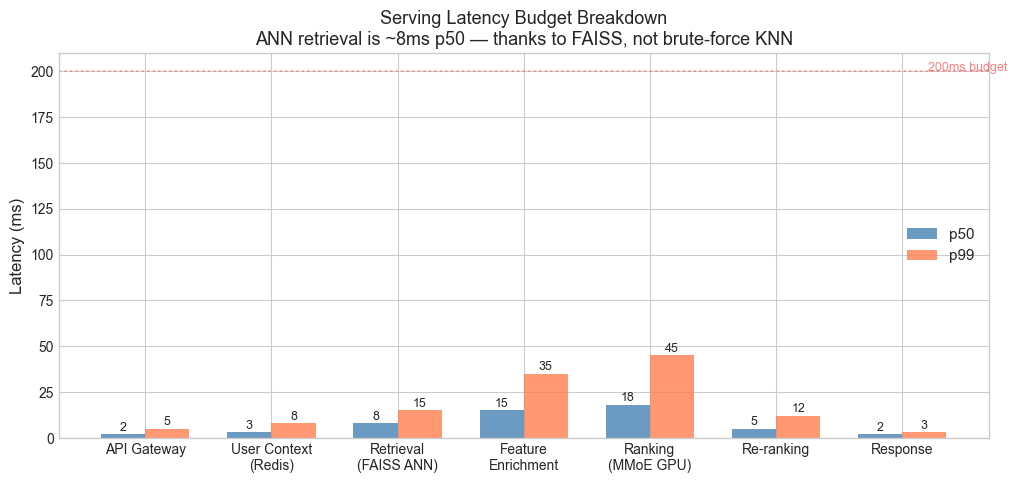

In [19]:
# Visualize: where does the 200ms latency budget go?
# (From our serving system design)

stages = [
    'API Gateway',
    'User Context\n(Redis)',
    'Retrieval\n(FAISS ANN)',
    'Feature\nEnrichment',
    'Ranking\n(MMoE GPU)',
    'Re-ranking',
    'Response'
]
p50_times = [2, 3, 8, 15, 18, 5, 2]
p99_times = [5, 8, 15, 35, 45, 12, 3]

fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(stages))
width = 0.35

bars1 = ax.bar(x - width/2, p50_times, width, label='p50', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, p99_times, width, label='p99', color='coral', alpha=0.8)

ax.set_ylabel('Latency (ms)', fontsize=12)
ax.set_title('Serving Latency Budget Breakdown\n'
             'ANN retrieval is ~8ms p50 — thanks to FAISS, not brute-force KNN', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(stages, fontsize=10)
ax.legend(fontsize=11)

# Add total line
ax.axhline(y=200, color='red', linestyle=':', alpha=0.3)
ax.text(6.2, 200, '200ms budget', fontsize=9, color='red', alpha=0.5)

# Annotate values
for bar in bars1:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., h + 0.5, f'{h}',
            ha='center', va='bottom', fontsize=9)
for bar in bars2:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., h + 0.5, f'{h}',
            ha='center', va='bottom', fontsize=9)

ax.text(0.5, -0.15, f'Total p50: {sum(p50_times)}ms  |  Total p99: {sum(p99_times)}ms  |  '
        f'With brute-force KNN, retrieval alone would be ~{brute_time_200k:.0f}ms',
        transform=ax.transAxes, fontsize=10, ha='center', style='italic')

plt.tight_layout()
plt.show()

---
## Summary

| Part | Algorithm | Key Insight |
|------|-----------|-------------|
| 1 | Brute-force | O(N) per query — breaks above ~50K items for real-time serving |
| 2 | LSH (from scratch) | Hash similar items into same bucket; tunable via tables/hashes |
| 3 | IVF (from scratch) | K-means partitioning; `nprobe` is the recall/speed knob |
| 4 | FAISS | Industry standard; supports IVF-Flat, IVF-PQ, HNSW |
| 5 | HNSW (hnswlib) | Graph-based, state-of-the-art recall/speed; `ef_search` is the knob |
| 6 | Annoy (Spotify) | Tree-based; `n_trees` is the knob |
| 7 | Comparison | HNSW wins on recall/speed; IVF-PQ wins on memory |
| 8 | Recommendation | Two-Tower + FAISS enables <10ms retrieval over 100K+ videos |

### The Pattern Across All ANN Methods

Every ANN algorithm has the **same structure**:

```
1. BUILD: Organize data into a structure that enables skipping
     LSH:  → hash tables
     IVF:  → K-means clusters (inverted lists)
     HNSW: → navigable graph layers
     Annoy: → random projection tree forest

2. QUERY: Use the structure to find a SMALL set of candidates
     LSH:  → items in matching buckets
     IVF:  → items in nprobe nearest clusters
     HNSW: → items found via greedy graph walk
     Annoy: → items in matching tree leaves

3. REFINE: Exact distance on candidates only (small N → fast)

Every method has ONE key tuning knob:
     LSH:  num_tables      (more tables → more candidates → higher recall)
     IVF:  nprobe           (more clusters → more candidates → higher recall)
     HNSW: ef_search        (wider graph search → more candidates → higher recall)
     Annoy: n_trees/search_k (more trees → more candidates → higher recall)
```

### Connection to the Video Recommendation Pipeline

```
This notebook                         Production system
─────────────                         ─────────────────
Random embeddings               →     Two-Tower learned embeddings
FAISS IVF-Flat (100K items)     →     FAISS IVF-PQ or HNSW (10M+ items)
Single-machine index            →     Sharded across machines + replicated
Rebuilt once                     →     Main index rebuilt every 4-6h + fresh index hourly
simulate_user_embedding()       →     User tower DNN forward pass
Category analysis               →     Ranking model (MMoE) + re-ranking
```